**Import required libraries**

In [1]:
import intake
import hvplot.pandas
import hvplot.xarray
import cartopy.crs as ccrs
from holoviews.operation.datashader import rasterize
import geoviews as gv
import matplotlib.pyplot as plt

/home/cheryl.morse/.conda/envs/DMAC_python/lib/python3.10/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.18, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


**Open the NWM intake catalog**

In [2]:
catalog = intake.open_catalog('s3://nextgen-dmac-cloud-ingest/nwm_ll/nwm_intake.yml')
(list(catalog))

['NWM_Best_CONUS_Short_Range',
 'NWM_Best_CONUS_Medium_Range',
 'NWM_Best_Alaska_Short_Range',
 'NWM_Best_Alaska_Medium_Range',
 'NWM_Best_Hawaii_Short_Range',
 'NWM_Best_PuertoRico_Short_Range']


&nbsp;

**Select the catalog entry to open**

In [3]:
cat = catalog['NWM_Best_CONUS_Short_Range']
ds = cat.to_dask()


&nbsp;

**Example of how to extract the data at a given timestep and plot the results**


&nbsp;
**1: Set the spatial bounds and time to extract**

In [4]:
lon_min= -180.
lat_min=24
lon_max=-60
lat_max=180
time_s='2024-02-26T18:00'

&nbsp;

**2: Extract the data**

In [5]:
ids = ((ds.latitude > lat_min) & (ds.latitude < lat_max) & (ds.longitude > lon_min) & (ds.longitude < lon_max)).compute()
s_ds = ds.sel(time=time_s).isel(feature_id=ids)

stream_ds = s_ds['streamflow']

&nbsp;

**3: Plot the extracted data**

In [6]:
df=stream_ds.to_pandas().to_frame()
df = df.assign(longitude = stream_ds.longitude)
df =df.assign(latitude=stream_ds.latitude)
df = df.assign(fid=s_ds.feature_id)
df = df.assign(fid=s_ds.link_id)
df.rename(columns={0:"streamflow"},inplace=True)

p = df.hvplot.points('longitude', 'latitude', crs=ccrs.PlateCarree(),
                     c='streamflow',size=14)
g = rasterize(p, aggregator='mean', x_sampling=0.001, y_sampling=0.001).opts(tools=['hover'], 
                 aspect='equal',colorbar=True,logz=True, cmap='viridis', clim=(1e-2, 2000), width=500,height=400 )

g  * gv.tile_sources.OSM

:DynamicMap   []
   :Overlay
      .Image.I :Image   [longitude,latitude]   (longitude_latitude streamflow)
      .WMTS.I  :WMTS   [Longitude,Latitude]

&nbsp;

**Example extracting a timeseries of data for a specific feature ID**


&nbsp;
**1: Set the set the feature ID and time bounds to extract**

In [7]:
feature_id = 22811611
start_t='2024-02-26T18:00'
end_t = '2024-03-02T10:00'


&nbsp;

**2: Extract and plot the timeseries data**

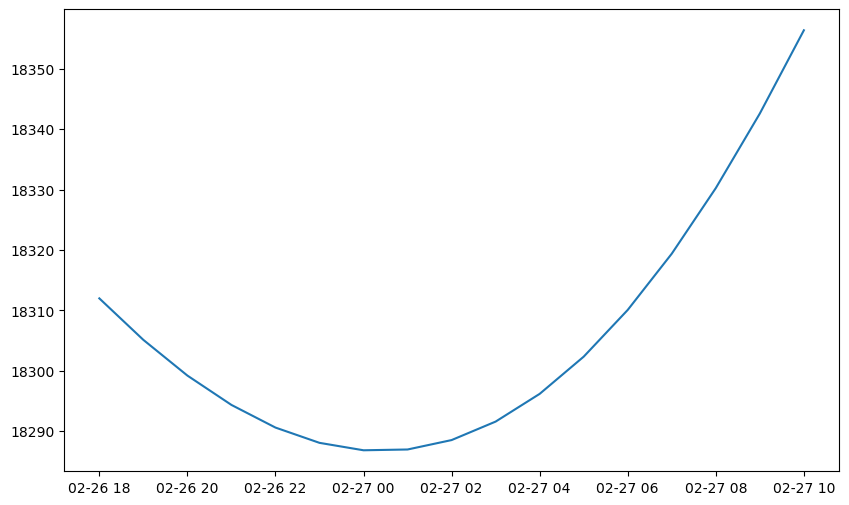

In [8]:

ts_ds = ds.sel(time=slice(start_t, end_t),feature_id=feature_id)
plt.figure(figsize=(10,6))
plt.plot(ts_ds.time, ts_ds.streamflow[:])

plt.show()